In [1]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pymorphy3
import re
from tqdm import tqdm

from preprocessing import full_prep, grade10fix

from lightgbm import LGBMClassifier


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



from xgboost import XGBClassifier

multiprocessing.cpu_count()

16

In [2]:
df = pd.read_json("kinopoisk.jsonl", lines=True, convert_dates = ['date'])

df = df[df['movie_name']!=10]
df = grade10_fix(df)

df.head()

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24,Плакали наши денежки ©,Good,10.0,"\n""Блеф» — одна из моих самых любимых комедий...."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04,None,Good,0.0,\nАдриано Челентано продолжает радовать нас св...
2,top250,Блеф (1976),17137,Flashman,2007-03-04,None,Good,10.0,"\nНесомненно, это один из великих фильмов 80-х..."
3,top250,Блеф (1976),17135,Sergio Tishin,2009-08-17,""" Черное, красное, ерунда это все. Выигрывает ...",Good,0.0,\nЭта фраза на мой взгляд отражает сюжет несом...
4,top250,Блеф (1976),17151,Фюльгья,2009-08-20,"«Он хотел убежать? Да! Блеф, блеф…»",Neutral,7.0,"\n- как пела Земфира, скорее всего, по соверше..."


## Обработка текста

In [7]:
# Создаём копию датасета для TF-IDF

df_bow = df[['content', 'grade3', 'grade10']].copy()

df_bow.head()


# Убираем знаки препинания, проводим лемматизацию, удаляем стоп-слова
df_bow = full_prep(df, punctuation = True, lemmatization = True, stop_words = True)

Удаление особых символов


100%|█████████████████████████████████████████████████████████████████████████| 36591/36591 [00:00<00:00, 39515.25it/s]


Токенизация


100%|█████████████████████████████████████████████████████████████████████████| 36591/36591 [00:03<00:00, 10296.50it/s]


Удаление стоп-слов


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████| 36591/36591 [00:15<00:00, 2313.34it/s]


In [8]:
df_bow.head()

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24,Плакали наши денежки ©,Good,10.0,"[блеф, одна, моих, самых, любимых, комедий, .,..."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04,None,Good,0.0,"[адриано, челентано, продолжает, радовать, сво..."
2,top250,Блеф (1976),17137,Flashman,2007-03-04,None,Good,10.0,"[несомненно, ,, это, великих, фильмов, 80х, го..."
3,top250,Блеф (1976),17135,Sergio Tishin,2009-08-17,""" Черное, красное, ерунда это все. Выигрывает ...",Good,0.0,"[эта, фраза, взгляд, отражает, сюжет, несомнен..."
4,top250,Блеф (1976),17151,Фюльгья,2009-08-20,"«Он хотел убежать? Да! Блеф, блеф…»",Neutral,7.0,"[пела, земфира, ,, скорее, ,, совершенно, друг..."


In [ ]:
df_bow['grade3'].value_counts()

In [32]:
#df_bow.to_pickle('lemmed_df.pkl')

## TF-IDF векторизация

In [161]:
# Для экономии времени загрузим готовый датасет с проведённым препроцессингом

df_bow = pd.read_csv('data/lemmed_df.csv').drop(columns = ['Unnamed: 0'])
df_bow

,content,grade3,grade10,clean_content,movie_name,review_id
0,блеф одна из моих самых любимых комедий этот ф...,Good,10.0,блеф самый любимый комедия фильм наверно смотр...,Блеф (1976),17144
1,адриано челентано продолжает радовать нас свои...,Good,0.0,адриано челентано продолжать радовать свой раб...,Блеф (1976),17139
2,несомненно это один из великих фильмов 80х год...,Good,10.0,несомненно это великий фильм 80х год исключите...,Блеф (1976),17137
3,эта фраза на мой взгляд отражает сюжет несомне...,Good,0.0,фраза взгляд отражать сюжет несомненно прекрас...,Блеф (1976),17135
4,как пела земфира скорее всего по совершенно др...,Neutral,7.0,петь земфира скорее весь совершенно повод ещё ...,Блеф (1976),17151
...,...,...,...,...,...,...
36586,ну с чего бы начать давненько я не писала отри...,Bad,2.0,начать давненько писать отрицательный рецензия...,Цветок дьявола (2010),25123
36587,можно начать с того что уже постер к фильму цв...,Bad,1.0,начать постер фильм цветок дьявол вызывать при...,Цветок дьявола (2010),25192
36588,фильм производства россии поэтому многие ожида...,Good,7.0,фильм производство россия поэтому многие ожида...,Цветок дьявола (2010),25080
36589,16 сентября на большие экраны вышел мистически...,Bad,0.0,16 сентябрь больший экран выйти мистический тр...,Цветок дьявола (2010),25088


In [36]:
# Если данные загружены из pickle соединим слова в списках в одну строку (только на локальной)
#df_bow['clean_content'] = df_bow['clean_content'].str.join(' ')

In [71]:
df_bow['grade3'].value_counts()

grade3
Good       27264
Bad         4751
Neutral     4576
Name: count, dtype: int64

In [39]:
count_vec = CountVectorizer()

count_vec.fit(df_bow['clean_content'])

CountVectorizer()

In [ ]:
matrix = count_vec.fit_transform(df_bow['clean_content'].values)
freqs = zip(count_vec.get_feature_names_out(), matrix.sum(axis=0))    
# sort from largest to smallest
A = np.squeeze(np.asarray(matrix.sum(axis=0)))
freqs = zip(count_vec.get_feature_names_out(), A)    
res = sorted(freqs, key=lambda x: -x[1])
res[:10]

In [11]:
def train_model(X_train,
                y_train,
                classificator,
                balancing = False,
                balancing_type = 'undersampling',
                use_grid_search = False,
                param_grid = None,
                cv_folds = 5,
                tfidf_max_features = 1500,
                tfidf_n_gram_range = (1, 1), **model_params):
    '''
    Функция обучения модели
    X_train - фичи обучающей выборки
    y_train - метки обучающей выборки
    classificator - выбранная модель
    balancing - делать балансировку или нет
    balancing_type - выбор типа балансировки undersampling/oversampling 
    use_grid_search - использовать поиск по сетке
    cv_folds - количество разбиений для StratifiedKfold
    tfidf_max_features - ограничение по TF-IDF
    tfidf_n_gram_range - ограничение по формату ngram
    **model_params - параметры для выбранной модели

    return: обученная модель, TF-IDF для выбранной обучающей выборки
    '''

    tfidf = TfidfVectorizer(max_features= tfidf_max_features, 
                            ngram_range=tfidf_n_gram_range)
    
    X_train = tfidf.fit_transform(X_train)
    if balancing:
        if balancing == 'undersampling':
            sampler = RandomUnderSampler() 
        else:
            sampler = RandomOverSampler()
       
        X_train, y_train = sampler.fit_resample(X_train, y_train)
       
    if use_grid_search:
        model = classificator()
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid = param_grid, scoring = 'f1_macro', cv = cv)
        grid.fit(X_train, y_train)
        print("Лучшие параметры:", grid.best_params_)
        return grid.best_estimator_, tfidf
    
    model = classificator(**model_params)
  
    model.fit(X_train, y_train)
    return model, tfidf


def classification_metrics(y_pred, y_test, proba):
    '''
    Функция подсчёта метрик классификации, матрицы смежности и ROC-кривой
    
    y_pred - предсказанные значения
    y_test - целевые тестовой выборки
    proba - (надо было сделать необязательным) логиты для построения roc-curve
    

    '''
    # Метрики классификации
    print(classification_report(y_test, y_pred))
    
    # Матрица смежности
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '.0f')
    
    # ROC-кривая
    if proba.shape[1]==2:
        fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
            

## Бинарная классификация

In [123]:
from sklearn.utils.class_weight import compute_class_weight


# Удалим нейтральные рецензии
X = df_bow[df_bow['grade3']!='Neutral']['clean_content'].values


OE = OrdinalEncoder(categories=[['Bad', 'Good']])
y = OE.fit_transform(df_bow[df_bow['grade3']!='Neutral']['grade3'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y.reshape(-1))

In [125]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = False,
                    tfidf_max_features = 1500, tfidf_n_gram_range= (1, 1), class_weight = dict(zip([0,1], weights)))

X_tfid = tfidf.transform(X_test)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 20433, number of negative: 3578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335292
[LightGBM] [Info] Number of data points in the train set: 24011, number of used features: 1500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498784 -> initscore=-0.004865
[LightGBM] [Info] Start training from score -0.004865


              precision    recall  f1-score   support

         0.0       0.69      0.86      0.77      1173
         1.0       0.97      0.93      0.95      6831

    accuracy                           0.92      8004
   macro avg       0.83      0.89      0.86      8004
weighted avg       0.93      0.92      0.93      8004



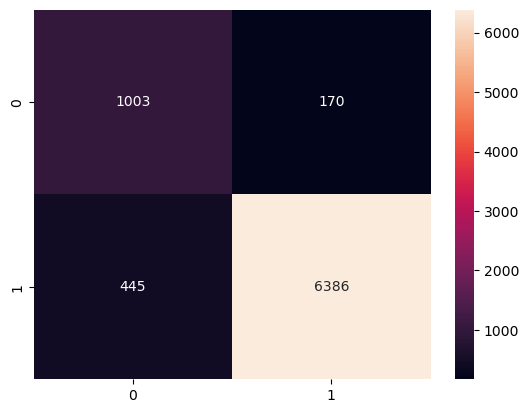

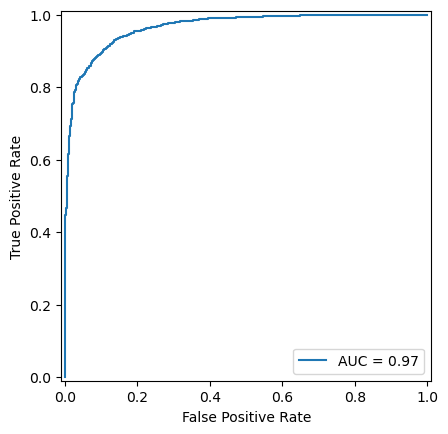

In [126]:
predictions = model.predict(X_tfid)

classification_metrics(predictions, y_test, model.predict_proba(X_tfid))

In [129]:
# Сэмплируем тестовую выборку, чтобы получить сбалансированные классы

rus = RandomUnderSampler()
X_tfid, y_test = rus.fit_resample(X_tfid, y_test)

predictions = model.predict(X_tfid)

accuracy = accuracy_score(y_test, predictions)
accuracy

0.8930093776641091

Бинарная классифиация с использованием взвешенной функции потерь
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1084
         1.0       0.93      0.87      0.90      1262

    accuracy                           0.89      2346
   macro avg       0.89      0.90      0.89      2346
weighted avg       0.90      0.89      0.89      2346

None


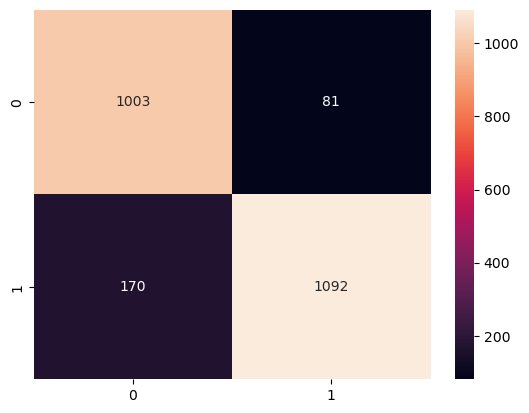

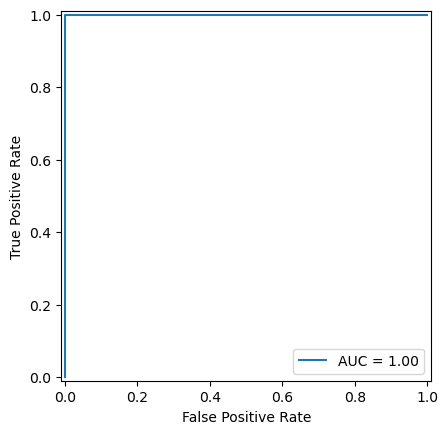

In [131]:
#Не знаю почему ROC-кривая сломалась
print('Бинарная классифиация с использованием взвешенной функции потерь')
print(classification_metrics(y_test, predictions, model.predict_proba(X_tfid)))

## Тройная классификация

In [13]:
from sklearn.utils.class_weight import compute_class_weight

X = df_bow['clean_content'].values

OE = OrdinalEncoder(categories=[['Bad', 'Neutral', 'Good']])
y = OE.fit_transform(df_bow['grade3'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y.reshape(-1))

weights = dict(zip(np.unique(y_test), weights))

In [15]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True,
                    tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692364
[LightGBM] [Info] Number of data points in the train set: 61362, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Тройная классификация с андерсэмплингом
              precision    recall  f1-score   support

         0.0       0.61      0.74      0.67      1191
         1.0       0.30      0.45      0.36      1147
         2.0       0.93      0.82      0.87      6810

    accuracy                           0.76      9148
   macro avg       0.61      0.67      0.63      9148
weighted avg       0.81      0.76      0.78      9148



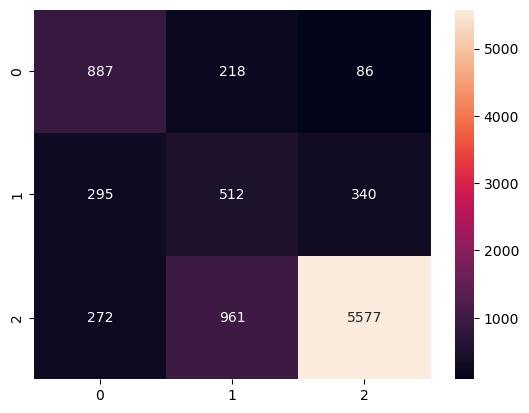

In [16]:
X_tfid = tfidf.transform(X_test)

predictions = model.predict(X_tfid)
print('Тройная классификация с андерсэмплингом')

classification_metrics(predictions, y_test, model.predict_proba(X_tfid))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692080
[LightGBM] [Info] Number of data points in the train set: 61362, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Тройная классификация с оверсэмплингом на сбалансированной тестовой выборке
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      1147
         1.0       0.57      0.45      0.50      1147
         2.0       0.69      0.81      0.74      1147

    accuracy                           0.66      3441
   macro avg       0.66      0.66      0.66      3441
weighted avg       0.66      0.66      0.66      3441



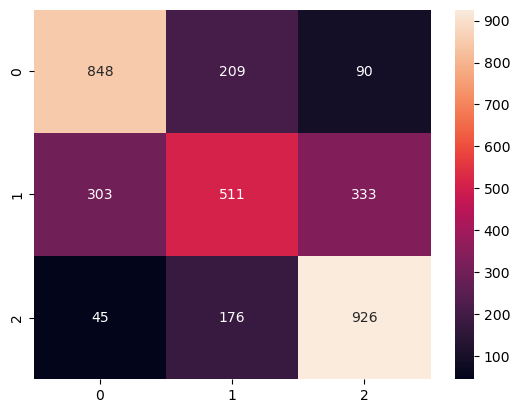

In [29]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True, balancing_type='oversampling',
                    tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1))


rus = RandomUnderSampler()

X_tfidf = tfidf.transform(X_test)
X_rus, y_rus = rus.fit_resample(X_tfidf, y_test)

predictions = model.predict(X_rus)


print('Тройная классификация с оверсэмплингом на сбалансированной тестовой выборке')
classification_metrics(predictions, y_rus, model.predict_proba(X_rus))

Тройная классификация с андерсэмплингом на сбалансированной тестовой выборке
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      1147
         1.0       0.59      0.44      0.51      1147
         2.0       0.69      0.82      0.75      1147

    accuracy                           0.67      3441
   macro avg       0.66      0.67      0.66      3441
weighted avg       0.66      0.67      0.66      3441



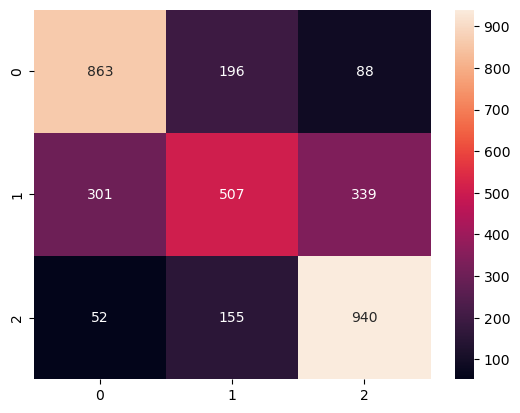

In [25]:
print('Тройная классификация с андерсэмплингом на сбалансированной тестовой выборке')
classification_metrics(predictions, y_rus, model.predict_proba(X_rus))

## Подбор классификатора

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

max_features = 3500
clf_list = []
clfs = [XGBClassifier, LGBMClassifier, RandomForestClassifier, SVC]
for clf in clfs:
    model, tfidf = train_model(X_train, y_train, clf, balancing = True,
                    tfidf_max_features = max_features, tfidf_n_gram_range= (1, 1))
    X_tfid = tfidf.transform(X_test)
    predictions = model.predict(X_tfid)
    print(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))
    clf_list.append(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))


0.6289989786246829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692662
[LightGBM] [Info] Number of data points in the train set: 61362, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
0.6316310406523528
0.5180688279840352


In [ ]:
dict(zip(['XGBClassifier', 'LGBMClassifier', 'RandomForestClassifier', 'SVC'], clf_list))
pd.DataFrame({'Classificator' : ['XGBClassifier', 'LGBMClassifier', 'RandomForestClassifier', 'SVC'], 
              'f1-macro': clf_list}).sort_values('f1-macro', ascending = False).reset_index(drop = True)

## Подбор параметра max_features для TF-IDF

In [286]:
max_features_search = list(range(0, 6000, 500))
max_features_search[0] = 100
accuracy_list = []
for feat in tqdm(max_features_search):
    model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True,
                    tfidf_max_features = feat, tfidf_n_gram_range= (1, 1))
    X_tfid = tfidf.transform(X_test)
    predictions = model.predict(X_tfid)
    print(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))
    accuracy_list.append(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))


    

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


  8%|██████▉                                                                            | 1/12 [00:04<00:53,  4.84s/it]

0.5154745869604939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115145
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 17%|█████████████▊                                                                     | 2/12 [00:11<01:01,  6.18s/it]

0.5863459055603185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176372
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 1000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 25%|████████████████████▊                                                              | 3/12 [00:20<01:06,  7.36s/it]

0.6076201599818402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213044
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 1500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 33%|███████████████████████████▋                                                       | 4/12 [00:31<01:08,  8.51s/it]

0.6095168106519313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236744
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 2000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 42%|██████████████████████████████████▌                                                | 5/12 [00:41<01:05,  9.39s/it]

0.6101410947857593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256201
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 2500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:53<01:00, 10.14s/it]

0.6141645263264511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271934
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 2999
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 58%|████████████████████████████████████████████████▍                                  | 7/12 [01:05<00:54, 10.87s/it]

0.610396479562386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283002
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3497
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [01:18<00:46, 11.57s/it]

0.6184213836946987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293693
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3987
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [01:32<00:36, 12.17s/it]

0.6116979417404144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304412
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 4479
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [01:46<00:25, 12.76s/it]

0.609747984573624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310313
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 4967
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [02:00<00:13, 13.17s/it]

0.6148219416386188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317014
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 5448
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:15<00:00, 11.31s/it]

0.6152223266262252


In [287]:
max_features_search = list(range(0, 6000, 500))
max_features_search[0] = 100
svc_list = []
for feat in tqdm(max_features_search):
    model, tfidf = train_model(X_train, y_train, SVC, balancing = True,
                    tfidf_max_features = feat, tfidf_n_gram_range= (1, 1))
    X_tfid = tfidf.transform(X_test)
    predictions = model.predict(X_tfid)
    print(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))
    svc_list.append(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))


    

  8%|██████▉                                                                            | 1/12 [00:43<07:57, 43.43s/it]

0.5127592679383957


 17%|█████████████▊                                                                     | 2/12 [02:10<11:28, 68.90s/it]

0.5905722942548163


 25%|████████████████████▊                                                              | 3/12 [03:59<13:04, 87.15s/it]

0.6068826366340702


 33%|███████████████████████████▎                                                      | 4/12 [06:09<13:53, 104.18s/it]

0.6202671378066141


 42%|██████████████████████████████████▏                                               | 5/12 [08:28<13:37, 116.72s/it]

0.6245877318729701


 50%|█████████████████████████████████████████                                         | 6/12 [10:53<12:38, 126.41s/it]

0.6208468540613495


 58%|███████████████████████████████████████████████▊                                  | 7/12 [13:23<11:10, 134.09s/it]

0.6198998746041152


 67%|██████████████████████████████████████████████████████▋                           | 8/12 [16:01<09:27, 141.88s/it]

0.6251153459073956


 75%|█████████████████████████████████████████████████████████████▌                    | 9/12 [18:42<07:22, 147.62s/it]

0.6243578137689733


 83%|███████████████████████████████████████████████████████████████████▌             | 10/12 [21:27<05:05, 153.00s/it]

0.6231380653235262


 92%|██████████████████████████████████████████████████████████████████████████▎      | 11/12 [29:45<04:18, 258.58s/it]

0.6282889736488505


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [32:49<00:00, 164.09s/it]

0.6278365739804056


In [135]:
predictions = model.predict(X_tfid)
accuracy = accuracy_score(y_test, predictions)


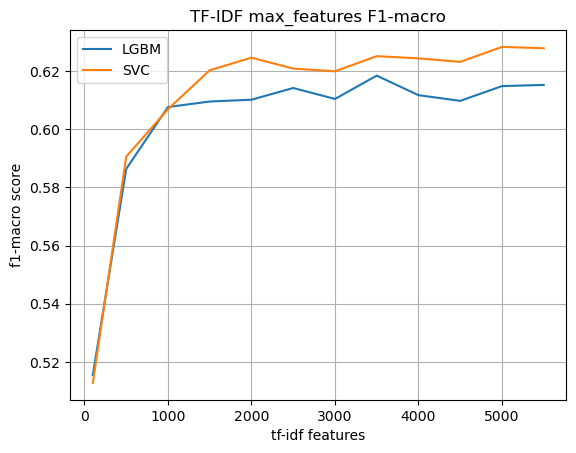

In [298]:
import matplotlib.pyplot as plt
plt.title('TF-IDF max_features F1-macro')
plt.plot(max_features_search, accuracy_list)
plt.plot(max_features_search, svc_list)
plt.ylabel('f1-macro score')
plt.xlabel('tf-idf features')
plt.grid()
plt.legend(['LGBM', 'SVC'])


In [351]:
max_features_search[np.argmax(accuracy_list)]

3500

In [380]:
import itertools
x = [1, 2, 3, 4]
ngram_range = [p for p in itertools.product(x, repeat=2)]
ngram_range = [a for a in ngram_range if a[0]<=a[1]]

In [382]:
ngram_list = []
for ngram in tqdm(ngram_range):
    model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True,
                    tfidf_max_features = 3500, tfidf_n_gram_range= ngram)
    X_tfid = tfidf.transform(X_test)
    predictions = model.predict(X_tfid)
    print(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))
    ngram_list.append(f1_score(y_test, predictions, labels=[0,1,2], average = 'macro'))


    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283270
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3499
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 10%|████████▎                                                                          | 1/10 [00:15<02:17, 15.27s/it]

0.6138920050230771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304230
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 20%|████████████████▌                                                                  | 2/10 [00:46<03:15, 24.42s/it]

0.6045820670587623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304710
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 30%|████████████████████████▉                                                          | 3/10 [01:44<04:40, 40.12s/it]

0.6023007427288365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305755
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 40%|█████████████████████████████████▏                                                 | 4/10 [03:25<06:25, 64.18s/it]

0.6093967449265881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82360
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3393
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:50<04:09, 49.93s/it]

0.5489793158381011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83166
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3401
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:46<03:28, 52.09s/it]

0.535673927040421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83475
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 3406
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:17<03:14, 64.69s/it]

0.5406413347029659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4421
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 338
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:52<01:50, 55.26s/it]

0.35359291069349813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4373
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 338
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:59<00:58, 58.83s/it]

0.3500715554917735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 10287, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:35<00:00, 51.55s/it]

0.09658064334939341


In [549]:
pd.DataFrame({'range' :ngram_range, 'ngram':ngram_list}).sort_values('ngram', ascending = False).reset_index(drop = True)

,range,ngram
0,"(1, 1)",0.613892
1,"(1, 4)",0.609397
2,"(1, 2)",0.604582
3,"(1, 3)",0.602301
4,"(2, 2)",0.548979
5,"(2, 4)",0.540641
6,"(2, 3)",0.535674
7,"(3, 3)",0.353593
8,"(3, 4)",0.350072
9,"(4, 4)",0.096581


## Grid Search CV

In [113]:
param_grid = {'num_leaves': [31, 40, 50],
              'n_estimators': [100, 200, 300]}



In [115]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True, use_grid_search=True, param_grid=param_grid,
                    tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1))
    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631291
[LightGBM] [Info] Number of data points in the train set: 49089, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632913
[LightGBM] [Info] Number of data points in the train set: 49089, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info

In [ ]:
# Лучшие параметры: {'n_estimators': 300, 'num_leaves': 50}

C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535312
[LightGBM] [Info] Number of data points in the train set: 27443, number of used features: 3500
[LightGBM] [Info] Start training from score -1.099027
[LightGBM] [Info] Start training from score -1.098989
[LightGBM] [Info] Start training from score -1.097821
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      1147
         1.0       0.60      0.27      0.37      1147
         2.0       0.59      0.93      0.72      1147

    accuracy                           0.64      3441
   macro avg       0.65      0.64      0.61      3441
weighted avg       0.65      0.64      0.61      3441



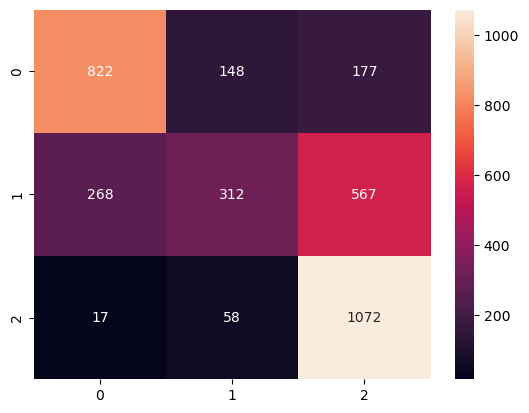

In [135]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = False,
                    tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1), class_weight = weights, num_leaves = 50, n_estimators = 300, objective = 'multiclass')



X_tfidf = tfidf.transform(X_test)

X_rus, y_rus = rus.fit_resample(X_tfidf, y_test)



predictions = model.predict(X_rus)

classification_metrics(predictions, y_rus, model.predict_proba(X_tfidf))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692650
[LightGBM] [Info] Number of data points in the train set: 61362, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.73      1147
         1.0       0.58      0.27      0.37      1147
         2.0       0.58      0.92      0.71      1147

    accuracy                           0.63      3441
   macro avg       0.64      0.63      0.60      3441
weighted avg       0.64      0.63      0.60      3441



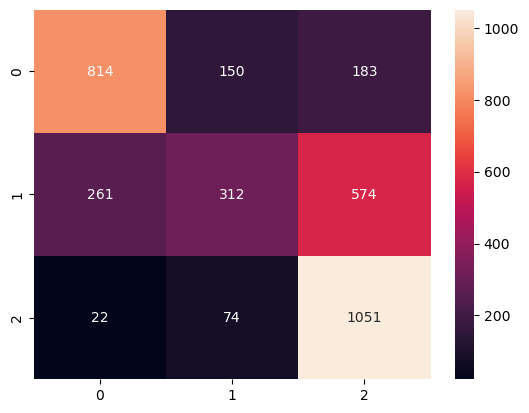

In [136]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True, balancing_type='oversampling',
                           tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1), 
                           n_estimators = 300, num_leaves = 50, objective = 'multiclass')




X_tfidf = tfidf.transform(X_test)
X_rus, y_rus = rus.fit_resample(X_tfidf, y_test)

predictions = model.predict(X_rus)

classification_metrics(predictions, y_rus, model.predict_proba(X_rus))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692382
[LightGBM] [Info] Number of data points in the train set: 61362, number of used features: 3500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72      1147
         1.0       0.60      0.28      0.38      1147
         2.0       0.58      0.92      0.71      1147

    accuracy                           0.63      3441
   macro avg       0.64      0.63      0.60      3441
weighted avg       0.64      0.63      0.60      3441



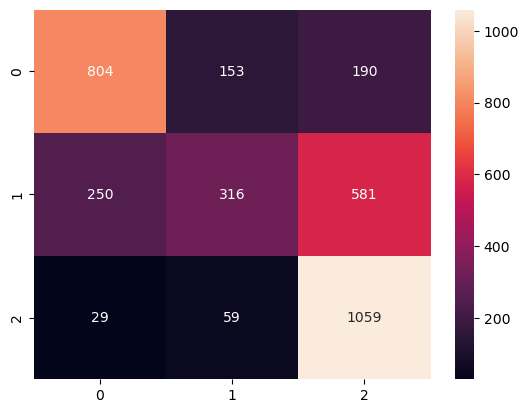

In [137]:
model, tfidf = train_model(X_train, y_train, LGBMClassifier, balancing = True, balancing_type='undersampling',
                           tfidf_max_features = 3500, tfidf_n_gram_range= (1, 1), 
                           n_estimators = 300, num_leaves = 50, objective = 'multiclass')




X_tfidf = tfidf.transform(X_test)
X_rus, y_rus = rus.fit_resample(X_tfidf, y_test)

predictions = model.predict(X_rus)

classification_metrics(predictions, y_rus, model.predict_proba(X_rus))